In [1]:
from skimage import io
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
import sklearn
import numpy.random
import cv2
import skimage
from skimage import img_as_float32, img_as_ubyte, img_as_uint
from skimage.color import rgb2gray, rgb2hsv, gray2rgb, rgba2rgb
from sklearn.metrics import confusion_matrix

## 1 Dataset

In [2]:
MAIN_FOLDER = "./puzzle_corners_1024x768/" 

DATA_FOLDER = MAIN_FOLDER + 'images-1024x768/image-{}.png'
LABEL_FOLDER = MAIN_FOLDER + 'masks-1024x768/mask-{}.png'

imgfiles = sorted(glob(DATA_FOLDER.replace('{}', '*')))
imgIds = [f.split('image-')[-1].split('.')[0] for f in imgfiles]


maskfiles = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
maskIds = [f.split('mask-')[-1].split('.')[0] for f in maskfiles]

trainImg, testImg, trainMask, testMask = train_test_split(imgIds, maskIds, test_size=0.29, random_state=42)
testImg, validImg, testMask, validMask = train_test_split(testImg,testMask, test_size=0.5, random_state=42)

print("Pieces for training : ", trainImg, "Size:", len(trainImg))
print("Pieces for validation : ", validImg,"Size:", len(validImg))
print("Pieces for testing : ", testImg,"Size:", len(testImg))

#load images
names=[trainImg, trainMask,testImg, testMask, validImg, validMask]
for i in range(0,6,2):
    data_files = [DATA_FOLDER.format(id) for id in names[i]]
    label_files = [LABEL_FOLDER.format(id) for id in names[i+1]]

    for m in range(len(data_files)):
        names[i][m]=img_as_float32(io.imread(data_files[m])/255)
        names[i+1][m]=img_as_float32(io.imread(label_files[m])/255)

        names[i][m]=cv2.resize(names[i][m], None, fx=0.4, fy=0.4)
        names[i+1][m]=cv2.resize(names[i+1][m], None, fx=0.4, fy=0.4)
        
        names[i][m]=names[i][m]/(names[i][m].max())
        names[i+1][m]=names[i+1][m]/(names[i+1][m].max())
        
        


Pieces for training :  ['39', '20', '24', '7', '22', '17', '23', '35', '38', '8', '0', '37', '36', '13', '19', '4', '1', '6', '28', '10', '41', '40', '3', '46', '18', '29', '25', '9', '27', '15', '47', '21', '34', '43'] Size: 34
Pieces for validation :  ['31', '11', '33', '14', '42', '12', '32'] Size: 7
Pieces for testing :  ['45', '44', '30', '26', '16', '5', '2'] Size: 7


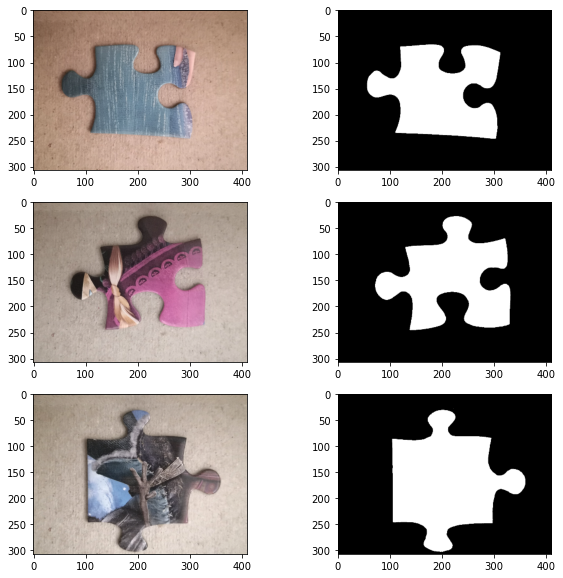

In [3]:
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
plt.imshow(trainImg[0])
plt.subplot(3,2,2)
plt.imshow(trainMask[0],cmap="gray")
plt.subplot(3,2,3)
plt.imshow(testImg[0])
plt.subplot(3,2,4)
plt.imshow(testMask[0],cmap="gray")
plt.subplot(3,2,5)
plt.imshow(validImg[0])
plt.subplot(3,2,6)
plt.imshow(validMask[0],cmap="gray")
plt.show()

## 2 Gaussian Mixture Models

In [4]:
def randInitCov(n): #covariance matrix should always be positive definite.
    A=np.random.random((n,n))
    A*=A.T
    iden=np.eye(n)
    A*=n*(iden*10000000) #multiply the identity matrix by another large positive number
    return A
    
class GMM():
    
    def __init__(self,featSet,K): #featSet is the pixels of foreground or background, K is number of components, initial setup of variables that will be needed
        self.featSet=featSet
        self.lenFeatSet=len(featSet[0])
        self.n=len(featSet)
        self.K=K
        self.lambdaK=np.ones(K)/K
        self.mu=np.random.random((K,self.lenFeatSet))*255.0
        self.cov=np.array([randInitCov(self.lenFeatSet) for i in range(K)])
        self.r=np.zeros((self.n,self.K))
        
    def Estep(self): #expectation step 
        numComp=self.K
        n=self.n
        avoidDiv0=0.000000001
        self.numeratorNorm=[]
        for k in range(numComp):
            self.numeratorNorm.append(multivariate_normal(mean=self.mu[k], cov=self.cov[k])) #right half of numerator in r formula for all K
            
        for i in range(n):
            for k in range(numComp):
                self.r[i,k]=self.lambdaK[k]*self.numeratorNorm[k].pdf(self.featSet[i]) #numerator value for r_ik
            self.r[i,:]=self.r[i,:]/(self.r[i, :].sum()+avoidDiv0)    # avoid divide by 0 so small number (avoidDiv0). divide all numerator values for k in the same i by the sum of all sumerator values at k in same i
                                                 #therefore r_ik formula complete
            
    def Mstep(self): #maximisation step
        numComp=self.K
        lenFeatSet=self.lenFeatSet
        n=self.n
        avoidDiv0=0.000000001
        
        denom=(np.sum(self.r, axis=0))+avoidDiv0 # (avoid dividing by 0 has no affect on accuracy as validated) seen as every denominator needs the sum of r_ik (except lambda) we can make it a variable
        
        #updating lambda variable
        self.lambdaK=denom/((self.r.sum()+avoidDiv0)*1.0) #avoid divide by 0 so small number (avoidDiv0) has no affect of accuracy.formula for updating lambda where denom in numerator in this case and *1.0 to ensure float
        
        # Updating the mean vector
        for k in range(numComp):
            self.mu[k]=(self.r[:,k].dot(self.featSet))/denom[k] #formula for updating mean

        # Updating the covariance matrices
        for k in range(numComp):
            covInit = np.zeros((lenFeatSet, lenFeatSet)) # Initiating the list of the covariance matrixes
            for i in range(n):
                numTerm=self.featSet[i, :]-self.mu[k] #(x-u) term in numerator
                covInit=covInit+self.r[i,k]*np.outer(numTerm,numTerm) #numerator formula (numTerm x numTerm.T)
            self.cov[k]=covInit/denom[k] #numerator/denominator
            
            if(np.linalg.det(self.cov[k])==0): #avoid singular matrix
                self.cov[k]=self.cov[k].astype(float)
                np.fill_diagonal(self.cov[k], self.cov[k].diagonal() + 0.00000001) #add very small number to diagonal avoid singular matrix
            
                  
    def EandMSteps(self):
        old_mu=self.mu.copy()
        print("Expectation step and Maximisation step")
        self.Estep()
        self.Mstep()
        dist=np.linalg.norm(old_mu-self.mu) #distance/change between previous mean to check if below tolerence to stop
        print("Current change in mean",dist)        
        return dist
    
    def train(self,tolerence):
        dist=tolerence
        count=0
        while dist>=tolerence and count<35: #count is there so will not possibly run until infinity
            dist=self.EandMSteps()
            count=count+1
          
    def likelihood(self,x): #likelihood
        l=np.zeros((x.shape[:-1]))
        numComp=self.K
        for k in range(numComp):
            l=l+self.lambdaK[k] * multivariate_normal(mean=self.mu[k], cov=self.cov[k]).pdf(x)
        return l
 

In [5]:
def probabilityCalc(x,b,f,prior):
    pF=f.likelihood(x) #for foreground
    pB=b.likelihood(x) #for background
    prior1=prior
    prior2=1-prior
    ans=np.divide((pF*prior1),((pF*prior1)+(pB*prior2)))
    
    ans[ans>0.5] = 1 #it must be a binary image
    ans[ans<0.5] = 0

    return ans

def FgAndBg(image, mask): #obtains the foreground and background pixels
    foreground=image[mask == 1] #when the mask pixel is 1, it is the puzzle/foreground
    background=image[mask == 0] #when the mask pixel is 0, it is the background
    return foreground, background

def priorCalc(image, mask): #prior calculation
    fg,bg=FgAndBg(image, mask)
    prior=len(fg)/float(len(fg)+len(bg))
    return prior

def featVectSetup(num_images,img,masks): #for RGB, DOG and other image will be passed as img to setup feature set

    image, mask=(img[0], masks[0])
    f, b=FgAndBg(image, mask) #foreground and background pixels
    prior=priorCalc(image,mask) #the prior
    
    for i in range(1,num_images):
        image, mask=(img[i], masks[i])
        newF, newB=FgAndBg(image, mask)
        f=np.vstack((f, newF)) #adds next image foreground pixels to foreground feature set
        b=np.vstack((b, newB)) #adds next image background pixels to background feature set
        prior=prior+priorCalc(image,mask) #add prior of new image to total prior
        
    return f,b,prior

def acc(predict, testMask):
    sumAns = 0
    for i in range(len(predict)):
        sumAns = sumAns + np.abs((int)(predict[i])-(int)(testMask[i])) #every time there is an incorrect pixel =1 else 0
    sumAns=1-(sumAns/(len(predict))) #1-incorrect pixels = correct pixels
    return sumAns

def DoG(size,sig,k):
    s=int(size/2) #to center it
    g=np.zeros((size,size),np.float32) #kernel type float
        
    for x in range(-s,s-1):
        for y in range(-s,s-1):
            p1=(1/(2*np.pi*sig**2))
            p2=np.exp(-1*((x**2+y**2))/(2*sig**2))
            p3=(1/(2*np.pi*k**2*sig**2))*np.exp(-1*((x**2+y**2))/(2*k**2*sig**2))
            g[x+s,y+s]=p1*p2-p3 #DoG formula
    return g

## Validation:

#### 1. RGB

In [6]:
def RGBTrain(trainImg,trainMask):
    fg,bg,prior=featVectSetup(len(trainImg), trainImg,trainMask)

    backModel=GMM(bg,3)#2,3,4,5,6,7,8 tested on with 3 being best
    foreModel=GMM(fg,3)

    print("Background")
    backModel.train(0.01)# 1, 0.5, 0.1, 0.05, 0.01,0.005,0.001 with 0.01 showing best accuracy

    print("\nForeground")
    foreModel.train(0.01)
    print()
    
    return backModel,foreModel,prior

def validPredict(testImg,testMask,backModel,foreModel,prior):
    avgAcc=0
    for i in range(len(validImg)):
        img=validImg[i].copy()

        predictImg=probabilityCalc(img,backModel,foreModel,prior)

        accu=acc(predictImg.flatten(),validMask[i].flatten())
        avgAcc=avgAcc+accu
        print("Accuracy for validation image",i,":",accu*100)
        print("Confusion matrix for validation image",i,":\n", confusion_matrix(validMask[i].flatten().astype(int),predictImg.flatten().astype(int)))

    return avgAcc

In [7]:
backModel,foreModel,prior=RGBTrain(trainImg,trainMask)
avgAcc=validPredict(validImg,validMask,backModel,foreModel,prior)

avgAcc=avgAcc/len(validImg)
print("\nAverage Accuracy for",3,"number of components and threshold",0.01,":", avgAcc*100,"\n\n\n") #best accuracy 98.63328377350781

Background
Expectation step and Maximisation step
Current change in mean 499.0462220381275
Expectation step and Maximisation step
Current change in mean 0.0002979428345854612

Foreground
Expectation step and Maximisation step
Current change in mean 502.84272150079823
Expectation step and Maximisation step
Current change in mean 0.001314366314424366

Accuracy for validation image 0 : 98.76777627711131
Confusion matrix for validation image 0 :
 [[86898  1183]
 [  368 37421]]
Accuracy for validation image 1 : 99.10145388098832
Confusion matrix for validation image 1 :
 [[98395  1131]
 [    0 26344]]
Accuracy for validation image 2 : 98.64860570429809
Confusion matrix for validation image 2 :
 [[91417  1642]
 [   59 32752]]
Accuracy for validation image 3 : 99.0156510685628
Confusion matrix for validation image 3 :
 [[93112   724]
 [  515 31519]]
Accuracy for validation image 4 : 98.15841741479304
Confusion matrix for validation image 4 :
 [[86339  2162]
 [  156 37213]]
Accuracy for valida

##### 6-fold cross-validation for RGB on best model

In [8]:
trainImg6Fold,trainMask6Fold = sklearn.utils.shuffle(trainImg, trainMask) #shuffled in same way
accuracies=[]

for i in range(6):
    left=(6*i)
    right=6*(i+1)
    validSetImg=trainImg6Fold[left:right] #validation Set
    validSetMask=trainMask6Fold[left:right]
    trainSet=[]
    trainMaskSet=[]
    
    for j in range(len(trainImg6Fold)):
        if(j<left or j>=right):
            trainSet.append(trainImg6Fold[j])
            trainMaskSet.append(trainMask6Fold[j])
            
    backModel,foreModel,prior=RGBTrain(trainSet,trainMaskSet)
    avgAcc=0
    for m in range(len(validSetImg)):
        img=validSetImg[m].copy()

        predictImg=probabilityCalc(img,backModel,foreModel,prior)

        accu=acc(predictImg.flatten(),validSetMask[m].flatten())
        avgAcc=avgAcc+accu

    avgAcc=avgAcc/len(validSetImg)
    print("\nAverage Accuracy for fold",i+1,":", avgAcc*100,"\n\n\n")
    accuracies.append(avgAcc*100)
    
print("\n\nAverage of All accuracies in 6-fold cross-validation is:",np.mean(accuracies))

Background
Expectation step and Maximisation step
Current change in mean 393.747201193837
Expectation step and Maximisation step
Current change in mean 2.6472230059653758e-05

Foreground
Expectation step and Maximisation step
Current change in mean 429.4058351934454
Expectation step and Maximisation step
Current change in mean 0.0009082540896257346


Average Accuracy for fold 1 : 97.85492968936205 



Background
Expectation step and Maximisation step
Current change in mean 442.77233755263427
Expectation step and Maximisation step
Current change in mean 8.087695894873568e-06

Foreground
Expectation step and Maximisation step
Current change in mean 393.2714284716536
Expectation step and Maximisation step
Current change in mean 0.0006108325618670122


Average Accuracy for fold 2 : 90.24310796853895 



Background
Expectation step and Maximisation step
Current change in mean 450.6874016119798
Expectation step and Maximisation step
Current change in mean 1.3667791676674129e-05

Foreground
E

### 2. RGB + Difference of Gaussian

In [9]:
def RGBGaussTrain(trainImg,trainMask):
    fg,bg,prior=featVectSetup(len(trainImg), trainImg,trainMask)
    diffOfGaussTrain=[]
    for i in range(len(trainImg)):
        doGKernel=DoG(20,3,2) #49,8,2
        imgDoGFilter=cv2.filter2D(trainImg[i],-1,doGKernel).astype(float)
        imgDoGFilter=np.clip(imgDoGFilter, a_min=0, a_max=255)
        imgDoG=(imgDoGFilter/imgDoGFilter.max()) #norm

        diffOfGaussTrain.append(imgDoG) #add dog image to set of dog training images

    dogF,dogB,prior=featVectSetup(34, diffOfGaussTrain,trainMask)

    fg=np.vstack((fg, dogF)) #adds DOG foreground feature set to RGB foreground feature set
    bg=np.vstack((bg, dogB)) #adds DOG background feature set to RGB background feature set

    backModel=GMM(bg,4)#2,3,4,5,6,7,8 tested on with 4 being best
    foreModel=GMM(fg,4)

    print("Background")
    backModel.train(0.01)# 1, 0.5, 0.1, 0.05, 0.01,0.005,0.001 with 0.01 showing best accuracy

    print("\nForeground")
    foreModel.train(0.01)  
    print()
    
    return backModel,foreModel,prior

In [10]:
backModel,foreModel,prior=RGBGaussTrain(trainImg,trainMask)
avgAcc=validPredict(validImg,validMask,backModel,foreModel,prior)

avgAcc=avgAcc/len(validImg)
print("\nAverage Accuracy for",4,"number of components and threshold",0.01,":", avgAcc*100,"\n\n\n") #best accuracy 99.13845350645224

Background
Expectation step and Maximisation step
Current change in mean 386.52285805274664
Expectation step and Maximisation step
Current change in mean 7.963988859189904e-05

Foreground
Expectation step and Maximisation step
Current change in mean 648.1335013705979
Expectation step and Maximisation step
Current change in mean 0.001410847211476337

Accuracy for validation image 0 : 98.94017637244777
Confusion matrix for validation image 0 :
 [[87466   615]
 [  719 37070]]
Accuracy for validation image 1 : 99.6258044013665
Confusion matrix for validation image 1 :
 [[99063   463]
 [    8 26336]]
Accuracy for validation image 2 : 99.45181536505919
Confusion matrix for validation image 2 :
 [[92443   616]
 [   74 32737]]
Accuracy for validation image 3 : 99.18248987050131
Confusion matrix for validation image 3 :
 [[93324   512]
 [  517 31517]]
Accuracy for validation image 4 : 99.0418685945817
Confusion matrix for validation image 4 :
 [[87477  1024]
 [  182 37187]]
Accuracy for validat

### 3. RGB + HSV + Vertical Prewitt + Horizontal Prewitt + Laplacian

In [11]:
def LastTrain(trainImg,trainMask):
    kVert=np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    kHor=np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])
    kLap=np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

    fg,bg,prior=featVectSetup(34, trainImg,trainMask)
    vertPrewittTrain=[]
    horPrewittTrain=[]
    laplacianTrain=[]
    hsvTrain=[]

    for i in range(len(trainImg)):
        imgVertFilter=cv2.filter2D(trainImg[i],-1,kVert).astype(float)
        imgVertFilter=np.clip(imgVertFilter, a_min=0, a_max=255)
        imgVert=(imgVertFilter/imgVertFilter.max()) #norm
        vertPrewittTrain.append(imgVert) #add vert prewitt image to set of vert prewitt training images  

        imgHorFilter=cv2.filter2D(trainImg[i],-1,kHor).astype(float)
        imgHorFilter=np.clip(imgHorFilter, a_min=0, a_max=255)
        imgHor=(imgHorFilter/imgHorFilter.max()) #norm
        horPrewittTrain.append(imgHor) #add horizontal prewitt image to set of horizontal prewitt training images

        imgLapFilter=cv2.filter2D(trainImg[i],-1,kLap).astype(float)
        imgLapFilter=np.clip(imgLapFilter, a_min=0, a_max=255)
        imgLap=(imgLapFilter/imgLapFilter.max()) #norm
        laplacianTrain.append(imgLap) #add laplacian image to set of laplacian training images

        imgHSVCol=cv2.cvtColor(trainImg[i],cv2.COLOR_RGB2HSV)
        imgHSVCol=np.clip(imgHSVCol, a_min=0, a_max=255)
        imgHSV=(imgHSVCol/imgHSVCol.max()) #norm
        hsvTrain.append(imgHSV) #add hsv image to set of hsv training images


    vertF,vertB,prior=featVectSetup(34, vertPrewittTrain,trainMask)
    horF,horB,prior=featVectSetup(34, horPrewittTrain,trainMask)
    lapF,lapB,prior=featVectSetup(34, laplacianTrain,trainMask)
    hsvF,hsvB,prior=featVectSetup(34, hsvTrain,trainMask)

    fg=np.vstack((fg,vertF,horF,lapF,hsvF)) #adds all foreground feature set to RGB foreground feature set
    bg=np.vstack((bg,vertB,horB,lapB,hsvB)) #adds all background feature set to RGB background feature set

    backModel=GMM(bg,4)#2,3,4,5,6,7,8 tested on with 4 being best
    foreModel=GMM(fg,4)

    print("Background")
    backModel.train(0.01)# 1, 0.5, 0.1, 0.05, 0.01,0.005,0.001 with 0.01 showing best accuracy

    print("\nForeground")
    foreModel.train(0.01)
    print()
    
    return backModel,foreModel,prior

In [12]:
backModel,foreModel,prior=LastTrain(trainImg,trainMask)
avgAcc=validPredict(validImg,validMask,backModel,foreModel,prior)

avgAcc=avgAcc/len(validImg)
print("\nAverage Accuracy for",4,"number of components and threshold",0.01,":", avgAcc*100,"\n\n\n") #best accuracy 91.28091341406667

Background
Expectation step and Maximisation step
Current change in mean 562.0369843327187
Expectation step and Maximisation step
Current change in mean 0.003458135448674938

Foreground
Expectation step and Maximisation step
Current change in mean 453.6236092922668
Expectation step and Maximisation step
Current change in mean 0.0005407200586955516

Accuracy for validation image 0 : 91.89083975530309
Confusion matrix for validation image 0 :
 [[86434  1647]
 [ 8560 29229]]
Accuracy for validation image 1 : 85.18948121077302
Confusion matrix for validation image 1 :
 [[91826  7700]
 [10942 15402]]
Accuracy for validation image 2 : 90.75951378406292
Confusion matrix for validation image 2 :
 [[90581  2478]
 [ 9153 23658]]
Accuracy for validation image 3 : 91.7208230714229
Confusion matrix for validation image 3 :
 [[92853   983]
 [ 9438 22596]]
Accuracy for validation image 4 : 95.25701120203385
Confusion matrix for validation image 4 :
 [[88123   378]
 [ 5592 31777]]
Accuracy for validat

# Testing
##### On best parameters from validation

##### 1. RGB

In [13]:
def testPredict(testImg,testMask,backModel,foreModel,prior):
    avgAcc=0
    for i in range(len(testImg)):
        plt.figure(figsize=(10,10))
        img=testImg[i]
        plt.subplot(1,3,1)
        plt.imshow(img)

        plt.subplot(1,3,2)
        predictImg=probabilityCalc(img,backModel,foreModel,prior)
        plt.imshow(predictImg,cmap="gray")

        plt.subplot(1,3,3)
        plt.imshow(testMask[i],cmap="gray") 

        accu=acc(predictImg.flatten(),testMask[i].flatten())
        avgAcc=avgAcc+accu
        print("Accuracy for test image",i,":",accu*100)
        print("Confusion matrix for test image",i,":\n", confusion_matrix(testMask[i].flatten().astype(int),predictImg.flatten().astype(int)))
    
    return avgAcc

Background
Expectation step and Maximisation step
Current change in mean 328.1212870195207
Expectation step and Maximisation step
Current change in mean 2.4893742077638268e-05

Foreground
Expectation step and Maximisation step
Current change in mean 312.7361440927283
Expectation step and Maximisation step
Current change in mean 0.001227577568419824

Accuracy for test image 0 : 97.25192659092716
Confusion matrix for test image 0 :
 [[93551  2208]
 [ 1251 28860]]
Accuracy for test image 1 : 99.20870739652023
Confusion matrix for test image 1 :
 [[95497   889]
 [  107 29377]]
Accuracy for test image 2 : 94.93525065543815
Confusion matrix for test image 2 :
 [[92882  2081]
 [ 4294 26613]]
Accuracy for test image 3 : 97.9828394375149
Confusion matrix for test image 3 :
 [[92401  1700]
 [  839 30930]]
Accuracy for test image 4 : 98.77413204099467
Confusion matrix for test image 4 :
 [[93787  1120]
 [  423 30540]]
Accuracy for test image 5 : 98.44681020100103
Confusion matrix for test image 5

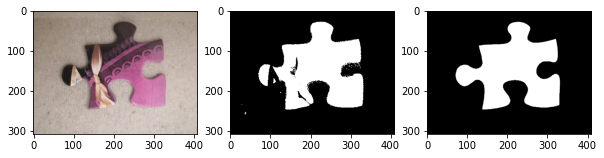

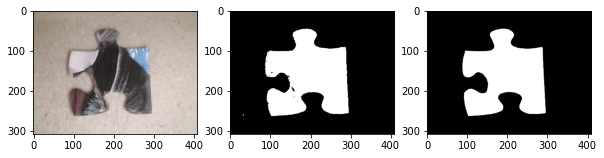

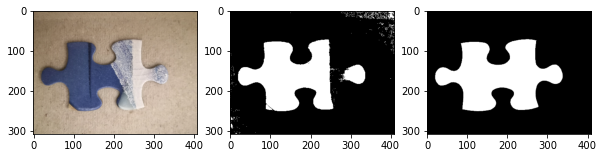

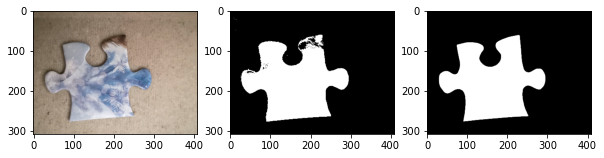

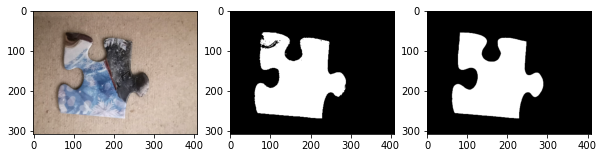

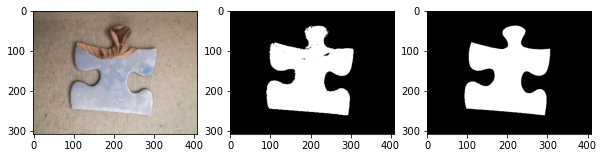

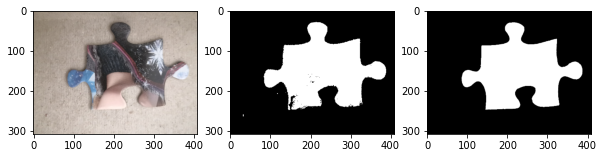

In [14]:
backModel,foreModel,prior=RGBTrain(trainImg,trainMask)
avgAcc=testPredict(testImg,testMask,backModel,foreModel,prior)


avgAcc=avgAcc/len(testImg)
print("\nAverage Accuracy for",3,"number of components and threshold",0.01,":", avgAcc*100,"\n\n\n") #accuracy 97.82428582778151

##### 2. RGB + Difference of Gaussian

Background
Expectation step and Maximisation step
Current change in mean 550.3099891476961
Expectation step and Maximisation step
Current change in mean 3.822206651665751e-05

Foreground
Expectation step and Maximisation step
Current change in mean 490.63282122735757
Expectation step and Maximisation step
Current change in mean 0.0014016952477207084

Accuracy for test image 0 : 97.81123381266386
Confusion matrix for test image 0 :
 [[94202  1557]
 [ 1198 28913]]
Accuracy for test image 1 : 99.43592595535075
Confusion matrix for test image 1 :
 [[95969   417]
 [  293 29191]]
Accuracy for test image 2 : 94.07245570827044
Confusion matrix for test image 2 :
 [[91241  3722]
 [ 3739 27168]]
Accuracy for test image 3 : 98.38166362119647
Confusion matrix for test image 3 :
 [[93228   873]
 [ 1164 30605]]
Accuracy for test image 4 : 99.05378565186304
Confusion matrix for test image 4 :
 [[94397   510]
 [  681 30282]]
Accuracy for test image 5 : 99.01326765710654
Confusion matrix for test image

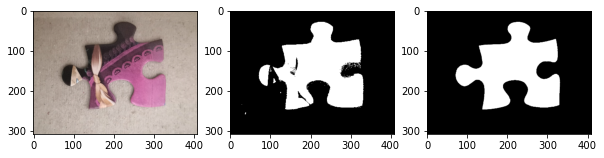

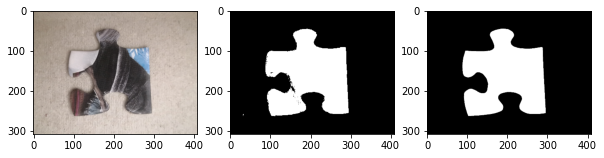

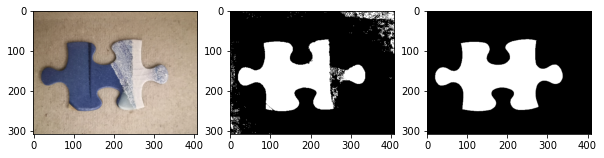

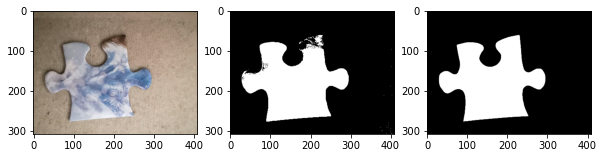

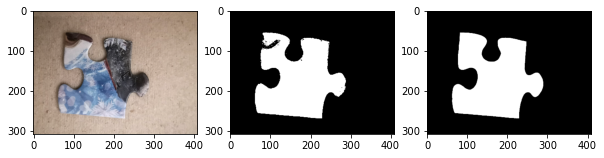

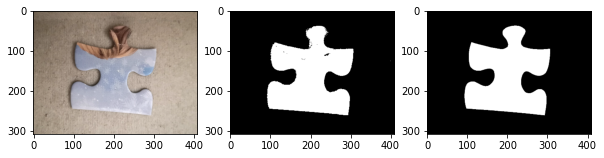

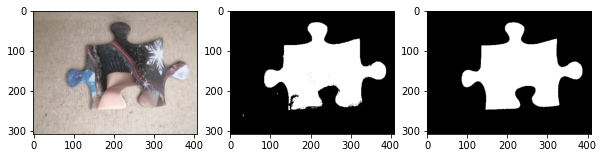

In [15]:
backModel,foreModel,prior=RGBGaussTrain(trainImg,trainMask)
avgAcc=testPredict(testImg,testMask,backModel,foreModel,prior)

avgAcc=avgAcc/len(testImg)
print("\nAverage Accuracy for",4,"number of components and threshold",0.01,":", avgAcc*100,"\n\n\n") # accuracy 98.05717917579362

##### 3. RGB + HSV + Vertical Prewitt + Horizontal Prewitt + Laplacian

Background
Expectation step and Maximisation step
Current change in mean 522.6015747358005
Expectation step and Maximisation step
Current change in mean 0.001532282945600466

Foreground
Expectation step and Maximisation step
Current change in mean 466.95646007079324
Expectation step and Maximisation step
Current change in mean 0.0024052619189240685

Accuracy for test image 0 : 89.54794629379519
Confusion matrix for test image 0 :
 [[91595  4164]
 [ 8992 21119]]
Accuracy for test image 1 : 85.14737427504568
Confusion matrix for test image 1 :
 [[91637  4749]
 [13946 15538]]
Accuracy for test image 2 : 89.10304282195916
Confusion matrix for test image 2 :
 [[82290 12673]
 [ 1043 29864]]
Accuracy for test image 3 : 96.97545086200049
Confusion matrix for test image 3 :
 [[91428  2673]
 [ 1134 30635]]
Accuracy for test image 4 : 95.51362516882497
Confusion matrix for test image 4 :
 [[94202   705]
 [ 4942 26021]]
Accuracy for test image 5 : 97.2948279971399
Confusion matrix for test image 5

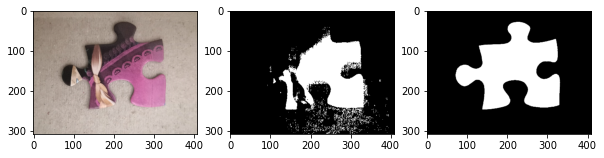

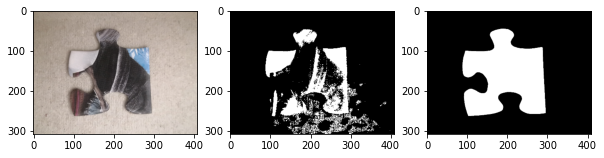

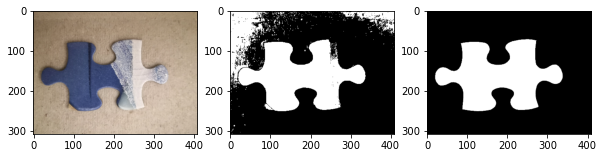

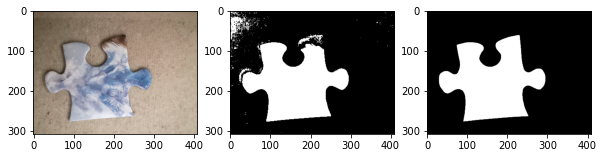

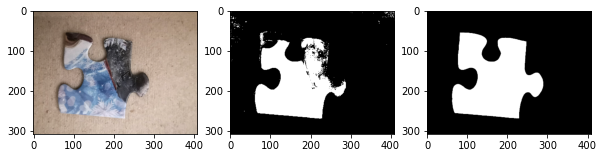

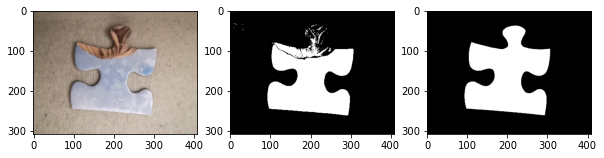

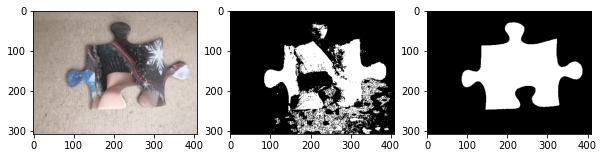

In [16]:
backModel,foreModel,prior=LastTrain(trainImg,trainMask)
avgAcc=testPredict(testImg,testMask,backModel,foreModel,prior)

avgAcc=avgAcc/len(testImg)
print("\nAverage Accuracy for",4,"number of components and threshold",0.01,":", avgAcc*100,"\n\n\n") #accuracy 91.1447184737087